# Chapter 3 Part 2:The shared corpus study
author: <span style="color:magenta">Poppy Riddle</span><br>
date: Mar 31, 2025
updated: July 31, 2025

## Data collection
- [ ] create sample collection from Crossref from part 1
- [ ] create shared corpus with works also found in OpenAlex matched on DOI
    - take DOI from Crossref sample df_collated2 export
    - send API call to OpenAlex for single work to select relevant elements or all and then refine down to elements needed for analysis
        - example API: https://api.openalex.org/works?filter=doi:10.7717/peerj.4375&select=doi,title,id,publication_year,language,abstract_inverted_index
    - reconstruct abstract from inverted 
        - [x] reconstruction code
- [ ] Crossref schema and OpenAlex schema comparison
    - Crossref schema: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html
    - OpenAlex schema: https://docs.openalex.org/api-entities/works/work-object
    - create diagram of this map
    - create dictionary to build later
- [ ] create mapping of metadata element from Crossref and its respective element in OpenAlex
    - cr_title -> openalex_title
    - cr_citedby_count -> openalex_citedby
    - etc
    - [ ] visualize/diagram
- [ ] quantify differences
    - [ ] exact match for numerical or absolute str values
        - cited_by
        - language
        - URL
        - doc_type
        - license 
    - [ ] clean Crossref data for jats tags - what about MathML? Use regex pattern from Part 1<br>
        #clean abstract<br>
        title_abstract_df['abstract'] = title_abstract_df['abstract'].apply(lambda x: x.replace('\n','').lstrip())<br>
        #the following is from: https://github.com/ourresearch/openalex-walden/blob/main/notebooks/ingest/PDF.py<br>
        title_abstract_df['abstract'] = title_abstract_df['abstract'].apply(lambda x: re.sub(r'<[^>]+>', '',x))<br>
    - [ ] Levenshtein ratio for str values that can accept some variation without changing meaning: https://rapidfuzz.github.io/Levenshtein/
        - title (may want to use Levenshtein.seqratio())
        - abstract (may want to use Levenshtein.seqratio())
- [ ] identify changes from publisher deposited data (Crossref) to OpenAlex
    - DOI, title, abstract, license type, license, cited-by, language, and document type.
- [ ] identify which error types occur: incorrect values, missing info, inconsistent values
- [ ] visualize: other pubs have used Sankey diagram to show change - other ways to do this? Or improve upon the Sankey approach?

## helpers:
### Python
- the Pyalex library: https://pypi.org/project/pyalex/#get-abstract
- how to uninvert: https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index
- 


In [64]:
# import libraries
import pandas as pd
import numpy as np
import os
import requests
import pickle
import json
from colorama import Fore,Back,Style
import time
import csv
import xmltodict #probably not needed here
from tqdm import tqdm

In [65]:
# get samples from part 1
#file = "data/part_1_sample.txt"
#df = pd.read_csv(file, sep='\t', encoding='utf-8', header=0)
#print(df.columns) # look at column names
##df.drop(['Unnamed: 0','level_0'], axis=1, inplace=True)
#df.head(1) # just look at first one

# load pickled data 

with open('data/part_1_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
df = pd.DataFrame(data)
# unpack 'license' into 'license_version' and 'license_type'
df[['license_version', 'license_type']] = df['license'].apply(lambda x:pd.Series(x))
# handle empty values

# remove 'object' and 'license'
df.drop(columns=['object','license'], inplace=True)

# handle missing values
df.isnull().sum()
df.dtypes
df.replace({None:np.nan,'None':np.nan}, inplace=True)
df.info()
print(len(df))



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10100 entries, ('journal-article', np.int64(0)) to ('book-chapter', np.int64(299))
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              10100 non-null  object
 1   type             10100 non-null  object
 2   title            10100 non-null  object
 3   abstract         10100 non-null  object
 4   language         4966 non-null   object
 5   cited_by         10100 non-null  int64 
 6   url              10100 non-null  object
 7   license_version  5909 non-null   object
 8   license_type     5909 non-null   object
dtypes: int64(1), object(8)
memory usage: 814.8+ KB
10100


In [66]:
# reconstruct abtract - from https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index


def reconstruct_abstract(abstract:dict)-> str:

    """
    This takes a dictionary of the inverted abstract
    and returns a string of the reconstructed abstract.

    Args:
    abstract should be in the form of a dictionary. 
    Example:
    abstract_inverted_index = {
    'Despite':[0],
    'growing':[1],
   'interest': [2],
    'in': [3],
    'Open': [4],
    'Access': [5],
    '...': [6]

    Returns:
    String 
    """

    # Create a list of (word, index) pairs
    word_index = []
    for k, v in abstract.items():
        for index in v:
            word_index.append([k, index])

    #print(word_index) # uncomment to see the sublists
    # Sort the list based on index
    word_index = sorted(word_index, key=lambda x: x[1]) # this sorts based on the second item in the sublist

    # Join the words with a space
    abstract = ' '.join([word for word, index in word_index])
    return abstract

In [100]:
# collect OpenAlex data
from functools import lru_cache

# send call to OpenAelx API
@lru_cache
def get_openalex_data(doi:str)->dict:
    """
    Arg: takes a DOI as a string without the resolver.
    Return: A dictionary of values.

    Note: oa_abstract is reconstructed from the function reconstruct_abstract()
    """
    URL = f"https://api.openalex.org/works?filter=doi:{doi}&select=doi,title,id,type,type_crossref,language,abstract_inverted_index,cited_by_count,is_paratext,primary_location"
    result = requests.get(URL)
    
    if result.status_code == 200:
        data = result.json()

        #parse json data into each element:
        oa_doi = data['results'][0]['doi'].lstrip('https://doi.org/')
        oa_title = data['results'][0]['title']
        oa_id = data['results'][0]['id']
        oa_type = data['results'][0]['type']
        oa_type_crossref = data['results'][0]['type_crossref']
        oa_language = data['results'][0]['language']
        oa_abstract_inverted_index = data['results'][0]['abstract_inverted_index']
        oa_cited_by_count = data['results'][0]['cited_by_count']
        oa_is_paratext = data['results'][0]['is_paratext']
        oa_primary_location_pdf_url = data['results'][0]['primary_location']['pdf_url']
        oa_license = data['results'][0]['primary_location']['license']
        oa_version = data['results'][0]['primary_location']['version']

    # reconstruct abstract
    oa_abstract = reconstruct_abstract(oa_abstract_inverted_index)

    return {'oa_doi': oa_doi,
            'oa_type':oa_type,
            'oa_type_crossref':oa_type_crossref,
            'oa_is_paratext':oa_is_paratext,
            'oa_title':oa_title,
            'oa_abstract':oa_abstract,
            'oa_language':oa_language,
            #'oa_abstract_inverted_index':oa_abstract_inverted_index,
            'oa_cited_by_count':oa_cited_by_count,
            'oa_primary_location_pdf_url':oa_primary_location_pdf_url,
            'oa_version':oa_version,
            'oa_license':oa_license,
            'oa_id':oa_id,
            }
    # sleep so that you are below the 10 per second limit or 100k per day.
    time.sleep(0.11)



In [101]:
# test on single doi
# 10.3390/su152215683
get_openalex_data("10.3390/su152215683")

{'oa_doi': '10.3390/su152215683',
 'oa_type': 'article',
 'oa_type_crossref': 'journal-article',
 'oa_is_paratext': False,
 'oa_title': 'Underpinning Quality Assurance: Identifying Core Testing Strategies for Multiple Layers of Internet-of-Things-Based Applications',
 'oa_abstract': 'The Internet of Things (IoT) constitutes a digitally integrated network of intelligent devices equipped with sensors, software, and communication capabilities, facilitating data exchange among a multitude of digital systems via the Internet. Despite its pivotal role in the software development life-cycle (SDLC) for ensuring software quality in terms of both functional and non-functional aspects, testing within this intricate software–hardware ecosystem has been somewhat overlooked. To address this, various testing techniques are applied for real-time minimization of failure rates in IoT applications. However, the execution of a comprehensive test suite for specific IoT software remains a complex undertakin

In [102]:
#WARNING: This will take nearly 2 hours to run the full 10,100!
from tqdm import tqdm

openalex_data = []

#REMOVE FOR FULL RUN!
df = df.head(20)

for doi in tqdm(df['DOI'],colour="MAGENTA"):
    result = get_openalex_data(doi)
    openalex_data.append(result)

df_openalex = pd.DataFrame(openalex_data)

print(Fore.MAGENTA + df_openalex.columns)


# save out the goods
folder_to_be_saved = 'Part_2_data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
#export as .csv but tab separated
file_to_be_saved = os.path.join(folder_to_be_saved, "part_2_OA_sample_collected.csv")

df_openalex.to_csv(file_to_be_saved, sep='\t', encoding='utf-8',na_rep='NA')

# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "part_2_OA_sample_collected.pkl")
df_openalex.to_pickle(pkl_to_be_saved)

df_openalex.head(2)

100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

Index(['oa_doi', 'oa_type', 'oa_type_crossref',
       'oa_is_paratext', 'oa_title', 'oa_abstract',
       'oa_language', 'oa_cited_by_count',
       'oa_primary_location_pdf_url', 'oa_version',
       'oa_license', 'oa_id'],
      dtype='object')


,oa_doi,oa_type,oa_type_crossref,oa_is_paratext,oa_title,oa_abstract,oa_language,oa_cited_by_count,oa_primary_location_pdf_url,oa_version,oa_license,oa_id
0,10.1521/soco.2021.39.5.543,article,journal-article,False,The Limits of Defaults: The Influence of Decis...,The stability of default effects to contextual...,en,4,None,None,None,https://openalex.org/W4206395497
1,10.1097/md.0000000000041851,article,journal-article,False,"Comparative analysis of demographic, clinical,...",The COVID-19 pandemic has brought a significan...,en,0,None,publishedVersion,cc-by-nc,https://openalex.org/W4408845899


In [103]:
# Compare Crossref df and oa df match on DOI
# new df with a boolean value if they share: doi, match_on_doi,...
# this will expand out for other boolean values

# match on df['doi'] and df_openalex['oa_doi']
match_on_doi_df = df[['DOI']].merge(df_openalex[['oa_doi']], left_on='DOI', right_on='oa_doi', how='outer')

match_on_doi_df['match_on_doi'] = match_on_doi_df['DOI'] == match_on_doi_df['oa_doi']

match_on_doi_df = match_on_doi_df.drop(['oa_doi'], axis=1)

print(Fore.CYAN + f"percent matched from Crossref: {len(match_on_doi_df)/len(df)*100:.1f}%")

match_on_doi_df


percent matched from Crossref: 100.0%


,DOI,match_on_doi
0,10.1002/jocb.1534,True
1,10.1039/d1re00315a,True
2,10.1097/md.0000000000041851,True
3,10.1186/s13052-024-01782-y,True
4,10.12957/cdf.2025.89476,True
5,10.1521/soco.2021.39.5.543,True
6,10.15407/internalmed2020.02b.029,True
7,10.16899/jcm.1241809,True
8,10.22214/ijraset.2023.49870,True
9,10.25136/2409-7136.2021.4.35160,True


# Analysis

- ✅ load and format data the same for easy comparison
- [ ] quantify differences
    - [ ] exact match for numerical or absolute str values
        - cited_by
        - language
        - URL
        - doc_type
        - license 
    - [ ] Levenshtein ratio for str values that can accept some variation without changing meaning: https://rapidfuzz.github.io/Levenshtein/
        - title (may want to use Levenshtein.seqratio())
        - abstract (may want to use Levenshtein.seqratio())

In [104]:
#make you a copy that does not have effects on the original
crossref_df = df.copy(deep=True)

#load you in the openalex data from the pickle
with open('Part_2_data/part_2_OA_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
openalex_df = pd.DataFrame(data)

In [111]:
print(Fore.LIGHTCYAN_EX + f"Crossref columns: \n{crossref_df.columns}")
print(Fore.LIGHTMAGENTA_EX + f"\n------\nOpenAlex columns: \n{openalex_df.columns}")

crossref_df.head(2).info()


Crossref columns: 
Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url',
       'license_version', 'license_type'],
      dtype='object')

------
OpenAlex columns: 
Index(['oa_doi', 'oa_type', 'oa_type_crossref', 'oa_is_paratext', 'oa_title',
       'oa_abstract', 'oa_language', 'oa_cited_by_count',
       'oa_primary_location_pdf_url', 'oa_version', 'oa_license', 'oa_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2 entries, ('journal-article', np.int64(0)) to ('journal-article', np.int64(1))
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              2 non-null      object
 1   type             2 non-null      object
 2   title            2 non-null      object
 3   abstract         2 non-null      object
 4   language         2 non-null      object
 5   cited_by         2 non-null      int64 
 6   url              2 non-null      object
 7   license_v

In [112]:
openalex_df.head(2).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   oa_doi                       2 non-null      object
 1   oa_type                      2 non-null      object
 2   oa_type_crossref             2 non-null      object
 3   oa_is_paratext               2 non-null      bool  
 4   oa_title                     2 non-null      object
 5   oa_abstract                  2 non-null      object
 6   oa_language                  2 non-null      object
 7   oa_cited_by_count            2 non-null      int64 
 8   oa_primary_location_pdf_url  0 non-null      object
 9   oa_version                   1 non-null      object
 10  oa_license                   1 non-null      object
 11  oa_id                        2 non-null      object
dtypes: bool(1), int64(1), object(10)
memory usage: 310.0+ bytes


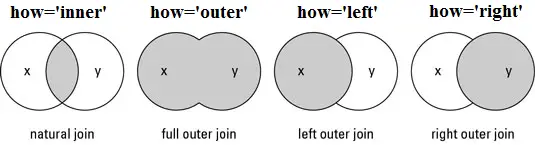<br>
source:https://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/

In [118]:
# compare exact match for values -> bool
# check for type - make this into a sankey diagram
# match on crossref_df[['DOI',type]] and openalex_df[['oa_doi','oa_type', 'oa_type_crossref']]
match_on_type_df = crossref_df[['DOI','type']].merge(openalex_df[['oa_doi','oa_type', 'oa_type_crossref']], left_on='DOI', right_on='oa_doi', how='outer')

match_on_type_df['match_on_type'] = match_on_type_df['type'] == match_on_type_df['oa_type']

match_on_type_df = match_on_type_df.drop(['oa_doi'], axis=1)
match_on_type_df_grouped = match_on_type_df.groupby(match_on_type_df['match_on_type'])['DOI'].count()
match_on_type_df_grouped


match_on_type
False    20
Name: DOI, dtype: int64

In [147]:
# re.sub('\s{2,}', ' ', text)
import re
# match on title
match_on_title_df = crossref_df[['DOI', 'title']].merge(openalex_df[['oa_doi','oa_title']], left_on='DOI', right_on='oa_doi', how='outer')

# text cleaning for extra spaces
match_on_title_df[['title','oa_title']] = match_on_title_df[['title', 'oa_title']].map(lambda x: re.sub(r'\s{2,}', ' ', str(x)))

# If you want to strip leading and trailing spaces as well
match_on_title_df = match_on_title_df.map(lambda x: x.strip())

match_on_title_df['match_on_title'] = match_on_title_df['title'] == match_on_title_df['oa_title']
match_on_title_df = match_on_title_df.drop(['oa_doi'], axis=1)
match_on_title_df_grouped = match_on_title_df.groupby(match_on_title_df['match_on_title'])['DOI'].count()
print(match_on_title_df_grouped)
match_on_title_df[match_on_title_df['match_on_title']==False]

#examine the false ones
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[7,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[7,2]}")
#

match_on_title
False     1
True     19
Name: DOI, dtype: int64
Crossref version: Results of Adjuvant Radiotherapy Based on Sedlis Criteria in Early Stage Cervical Cancer
OpenAlex version: Erken Evre Serviks Kanserinde Sedlis Kriterleri Gözönünde Bulundurularak Uygulanan Adjuvant Radyoterapi Sonuçları


### overall changes
- [ ] identify changes from publisher deposited data (Crossref) to OpenAlex
    - DOI, title, abstract, license type, license, cited-by, language, and document type -> 0 for missing, 1 for present
    - create table


### DOI specific metadata
- [ ] Change in DOI URL from Crossref to OpenAlex, (0,1)
- [ ] count of those that have https vs http (as an indicator of link rot)
- [ ] count of HTTP status code on all URLs
- [ ] count of those not working (such as 400)
- [ ] create table

### publication type
- [ ] count of each type
- [ ] change from Crossref to Openalex, 0,1?
- [ ] % distribution 
- [ ] maybe a good place for a sankey diagram showing changes

### title
- [ ] change between Crossref and OpenAlex 0,1?
- [ ] count of tokens in each
- [ ] count of stopwords
- [ ] count of punctuation
- [ ] count of special char, formating char
- [ ] count of numerals
- [ ] count of tags or other non-text elements
- [ ] visualize distribution of these across both databases

### abstract
- [ ] change between Crossref and OpenAlex?
- [ ] count of tokens in each
- [ ] count of stopwords
- [ ] count of punctuation
- [ ] count of special char, formating char
- [ ] count of numerals
- [ ] count of tags or other non-text elements
- [ ] visualize distribution of these across both databases

## cited by count
- [ ] std dev of differences between two samples
- [ ] n with change
- [ ] % affected
- [ ] visualize to see if one database favors more than the other

### license
- [ ] change between Crossref and OpenAlex?
- [ ] count of types for each
- [ ] count of those with licenses vs without
- [ ] % of those with 
- [ ] count of common or proprietary licenses
- [ ] visualization of distribution of license types

### languages
- [ ] change between Crossref and OpenAlex
- [ ] count of types
- [ ] % declared in abstract
    - found in XML API
- [ ] % declared in journal title level
    - found in REST API
- [ ] visualization of distribution of language types

## Qualitative Analysis

### License
IF there are differences, an examination of changes between two sources. This may require a subset based on filtering from above. 
- [ ] comparison of license in each source
- [ ] apply an error classification: incorrect, missing, inconsistent

### title and abstract
- [ ] filter df from above for those with differences 
    - [ ] use subset if needed due to quantity
- [ ] compare title from each source based on Levenshtein seqratio
- [ ] compare abstract from each source based on Levenshtein seqratio
- [ ] apply classification
- [ ] identify error types 


# diagram of crosswalk between Crossref and OpenAlex

- [ ] Crossref schema and OpenAlex schema comparison
    - Crossref schema: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html
    - OpenAlex schema: https://docs.openalex.org/api-entities/works/work-object
    - create diagram of this map
    - create dictionary to build later
    - [ ] create mapping of metadata element from Crossref and its respective element in OpenAlex
    - cr_title -> openalex_title
    - cr_citedby_count -> openalex_citedby
    - etc

In [34]:
#parse json data into each element:
data = data #returned from OpenAlex REST API
oa_doi = data['results'][0]['doi'].lstrip('https://doi.org/')
oa_title = data['results'][0]['title']
oa_id = data['results'][0]['id']
oa_type = data['results'][0]['type']
oa_type_crossref = data['results'][0]['type_crossref']
oa_language = data['results'][0]['language']
oa_abstract_inverted_index = data['results'][0]['abstract_inverted_index']
oa_cited_by_count = data['results'][0]['cited_by_count']
oa_is_paratext = data['results'][0]['is_paratext']
oa_primary_location_pdf_url = data['results'][0]['primary_location']['pdf_url']
oa_license = data['results'][0]['primary_location']['license']
oa_version = data['results'][0]['primary_location']['version']

KeyError: 'results'